## The Data

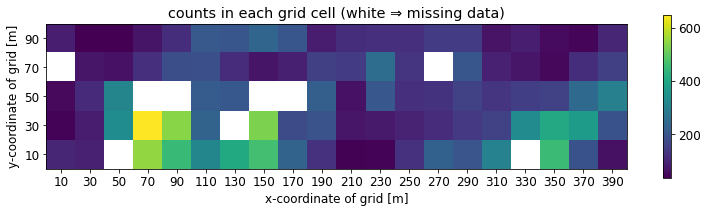

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

## The Strategy

We can use the kelp counts in each grid square to estimate the number of kelp in the missing grid cells. We achieve this by creating two models. The first, complete pooling, will assume there is no variation among grid cells and will have a single distribution over $\lambda$ with set parameters. The second, partial pooling, will assume variation between grid cells and will have a posterior distribution over $\lambda$ for each cell. Despite our assumption that there is variation among grid cells, we still think that there is some factor of similarity between the cells and thus use the same hyperpriors such that the priors have some dependency between grid cells.

The steps we will take here are as follows:
1. For complete pooling, decide on a prior distribution and tune the parameters such that it produces reasonable prior predictive samples. We expect to see ~0-800 kelp plants per grid cell so the majority of samples should lie within this range. Since $\lambda$ (the rate parameter of the poisson distribution) is equal to both the mean and variance of counts, we would expect $\lambda$ to lie between 0 and 800.
2. Run the model with the data, and check summary statistics. Here, we will ensure that $\hat{R}$ values are <=1.01 and that the ESS values are >10% of the number of samples.
3. Increase tuning steps, increase target accept and/or reparameterise as needed to ensure diagnostics are good and that the sampler has explored the entire posterior evenly.
4. Once the model is working correctly, plot the posterior distributions over all parameters and interpret these posteriors.
5. For partial pooling, decide on hyperpriors and tune these such that they produce reasonable prior predictive samples as in step 1. Repeat steps 2-4 for this model.
6. Compare posteriors for the two models and use these to make predictions about the values in the missing grid cells. 

## Complete Pooling

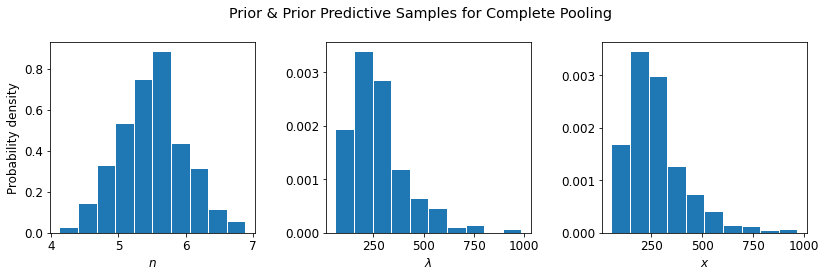

In [9]:
import pymc as pm
import arviz as az

# prior predictive checks
with pm.Model() as model:
    
    # prior (tranform normal onto positive real numbers)
    n = pm.Normal('n', mu = 5.5, sigma = 0.5)
    l = pm.Deterministic('l', pm.math.exp(n))
    
    # likelihood
    pm.Poisson('x', mu = l, observed = 91)
    
    inferencep_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
fig.tight_layout(pad = 3)

ax[0].hist(inferencep_prior.prior.n.values.flatten(), bins=10, density=True, edgecolor='white')
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('Probability density')

ax[1].hist(inferencep_prior.prior.l.values.flatten(), bins=10, density=True, edgecolor='white')
ax[1].set_xlabel('$\lambda$')

ax[2].hist(inferencep_prior.prior_predictive.x.values.flatten(), bins=10, density=True, edgecolor='white')
ax[2].set_xlabel('$x$')

fig.suptitle('Prior & Prior Predictive Samples for Complete Pooling')
plt.show()

For complete pooling, we can use a $log(\lambda) = n$ prior where $n$ is normally distributed with parameters $\mu = 5.5$ and $\sigma = 0.5$. These parameters produce a reasonable prior predictive distribution ($x$ above), with the majority of samples lying between 0 and 800. Theoretically, this makes sense since ~99.7% of our density for $n$ lies between 4 and 7, corresponding to $\lambda$ values of $e^4$ (55) and $e^7$ (1097).

We also see that the $\lambda$ prior has an almost identical distribution to that of $x$. This is because the mean of the distribution is in fact the rate parameter, so the values of $\lambda$ are the same as the mean of it's poisson distribution. We can now run the model with the data as below.

I have chosen to use a transformed normal distribution for this prior in place of a uniform distribution to account for a wider range of values. We don't know for certain that 800 is a strict upper bound, thus having a small probability mass above this can account for unexpected data.

In [11]:
# remove nan from data for model
data_flat = data.flatten()
d = [i for i in data_flat if str(i) != 'nan']
n_samples = 2000

with pm.Model() as model:
    
    # prior (tranform normal onto positive real numbers)
    n = pm.Normal('n', mu = 5.5, sigma = 0.5)
    l = pm.Deterministic('l', pm.math.exp(n))
    
    # likelihood
    pm.Poisson('x', mu = l, observed = d)
    
    # sampling
    inferencec = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n,5.196,0.008,5.181,5.211,0.000,0.000,3576.0,5735.0,1.0
l,180.537,1.415,177.943,183.286,0.024,0.017,3576.0,5735.0,1.0


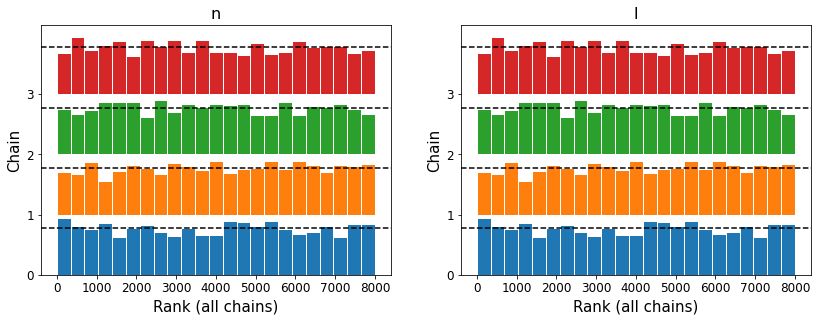

In [12]:
# diagnostic visuals
az.plot_rank(inferencec)
display(az.summary(inferencec))

# diagnostic checks
assert all(az.rhat(inferencec) <= 1.01)
assert all(az.ess(inferencec) > n_samples/10)

$\hat{R}$ for both parameters is 1.0, and effective sample sizes are greater than 10% of the sample size. Furthermore, the rank plots look roughly uniformly-distributed. Since the diagnostic checks are all fine, we have no reason to expect that the sampler is working incorrectly. We thus assume that it is 'randomly' sampling from the entire posterior distribution.

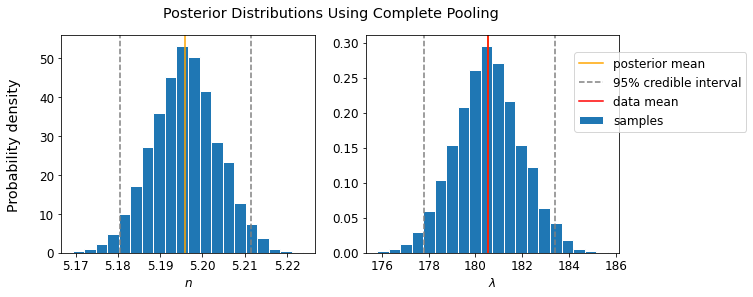

95% credible interval for l: [177.78, 183.38]
Posterior mean of l: 180.54
Data mean: 180.53


In [34]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
var = ['n', 'l']
xlabel = ['$n$', '$\lambda$']

# plot posterior for each variable
for i in range(2):
    valsc = inferencec.posterior[var[i]].values.flatten()

    ax[i].hist(valsc, bins = 20, edgecolor = 'white', density = True, label = 'samples')
    ax[i].axvline(np.mean(valsc), color = 'orange', label = 'posterior mean')
    ax[i].axvline(np.percentile(valsc, 2.5), color = 'gray', linestyle = '--', label = '95% credible interval')
    ax[i].axvline(np.percentile(valsc, 97.5), color = 'gray', linestyle = '--')
    ax[i].set_xlabel(xlabel[i])
    
    if i == 1:
        ax[i].axvline(np.mean(d), color = 'red', label = 'data mean')
        ax[i].legend(bbox_to_anchor=(0.8, 0.95))
        
fig.supylabel('Probability density', x = 0.05)
fig.suptitle('Posterior Distributions Using Complete Pooling')
plt.show()

l_valsc = inferencec.posterior.l.values.flatten()
print('95% credible interval for l:', [round(np.percentile(l_valsc, 2.5), 2), round(np.percentile(l_valsc, 97.5), 2)])
print('Posterior mean of l:', round(np.mean(l_valsc), 2))
print('Data mean:', round(np.mean(d), 2))

Plotting the posterior distributions, we see that there is a 95% probability that the true value for $\lambda$ lies between ~178 and ~183. We also see that the posterior mean and data mean lie exactly on top of each other. Since the posterior is an updated point estimate of the rate parameter (equal to the mean), we should expect that the sample mean converges to the mean of the data.

## Partial Pooling

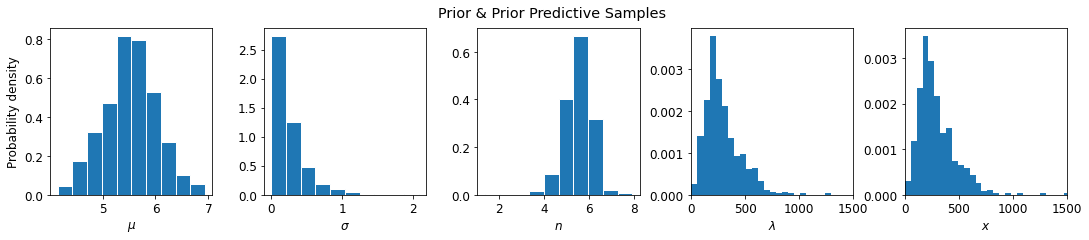

In [45]:
# prior predictive checks
with pm.Model() as model:
    
    # hyperpriors
    mu = pm.Normal('mu', mu = 5.5, sigma = 0.5)
    sigma = pm.Exponential('sigma', lam = 4)
    
    # prior (tranform normal onto positive real numbers)
    n = pm.Normal('n', mu = mu, sigma = sigma)
    l = pm.Deterministic('l', pm.math.exp(n))
    
    # likelihood
    pm.Poisson('x', mu = l, observed = len(d))
    
    inferencep_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(1, 5, figsize = (15, 3))
fig.tight_layout(pad = 1)

ax[0].hist(inferencep_prior.prior.mu.values.flatten(), bins=10, density=True, edgecolor='white')
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('Probability density')

ax[1].hist(inferencep_prior.prior.sigma.values.flatten(), bins=10, density=True, edgecolor='white')
ax[1].set_xlabel('$\sigma$')

ax[2].hist(inferencep_prior.prior.n.values.flatten(), bins=10, density=True, edgecolor='white')
ax[2].set_xlabel('$n$')

ax[3].hist(inferencep_prior.prior.l.values.flatten(), bins=50, density=True)
ax[3].set_xlabel('$\lambda$')
ax[3].set_xlim(0, 1500)

ax[4].hist(inferencep_prior.prior_predictive.x.values.flatten(), bins=50, density=True)
ax[4].set_xlabel('$x$')
ax[4].set_xlim(0, 1500)

fig.suptitle('Prior & Prior Predictive Samples', y = 1.02)
plt.show()

For the partial pooling model, we should add in hyperpriors over $\mu$ and $\sigma$. I have kept the mean of $\mu$ the same as $\mu$ for the complete pooling model. A value of 0.5 for $\sigma$ for the $\mu$ hyperprior means that 99.7% of the density of $\mu$ will lie between 4 and 7. This seems reasonable, since a value of 4 for $n$ would produce a $\lambda$ of $e^{4}$ (55) and 7 would produce a value of $e^{7}$ (1097). This is a wide range, but we see from the distributions for $\lambda$ and $x$ that this is reasonable, since most of their density lies between 0 and 800. I have used an exponential distribution for $\sigma$ to place most probability density nearer 0, since we don't expect much difference in the variation in the distributions over $\lambda$. We can now sample from the posterior using the data.

In [28]:
with pm.Model() as model:

    # hyperpriors
    mu = pm.Normal('mu', mu = 5.5, sigma = 0.5)
    sigma = pm.Exponential('sigma', lam = 4)
    
    # prior (tranform normal onto positive real numbers)
    n = pm.Normal('n', mu = mu, sigma = sigma, shape = len(d))
    l = pm.Deterministic('l', pm.math.exp(n))
    
    # likelihood
    pm.Poisson('x', mu = l, observed = d)
    
    inferencep = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, n]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.


C:\Users\cathe\anaconda3\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (184) in plot_rank, generating only 40 plots
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.979,0.072,4.847,5.116,0.001,0.000,13916.0,4849.0,1.0
n[0],4.618,0.098,4.437,4.801,0.001,0.001,13885.0,5202.0,1.0
n[1],4.526,0.105,4.334,4.723,0.001,0.001,15157.0,5904.0,1.0
n[2],6.304,0.043,6.227,6.389,0.000,0.000,13799.0,5595.0,1.0
n[3],6.102,0.047,6.015,6.193,0.000,0.000,14059.0,5421.0,1.0
...,...,...,...,...,...,...,...,...,...
l[86],70.560,8.182,55.261,85.682,0.065,0.047,15620.0,5966.0,1.0
l[87],88.003,9.158,71.423,105.129,0.078,0.056,13532.0,6047.0,1.0
l[88],56.032,7.189,43.078,69.690,0.059,0.042,14670.0,6051.0,1.0
l[89],46.500,6.679,34.816,59.590,0.053,0.038,15918.0,5780.0,1.0


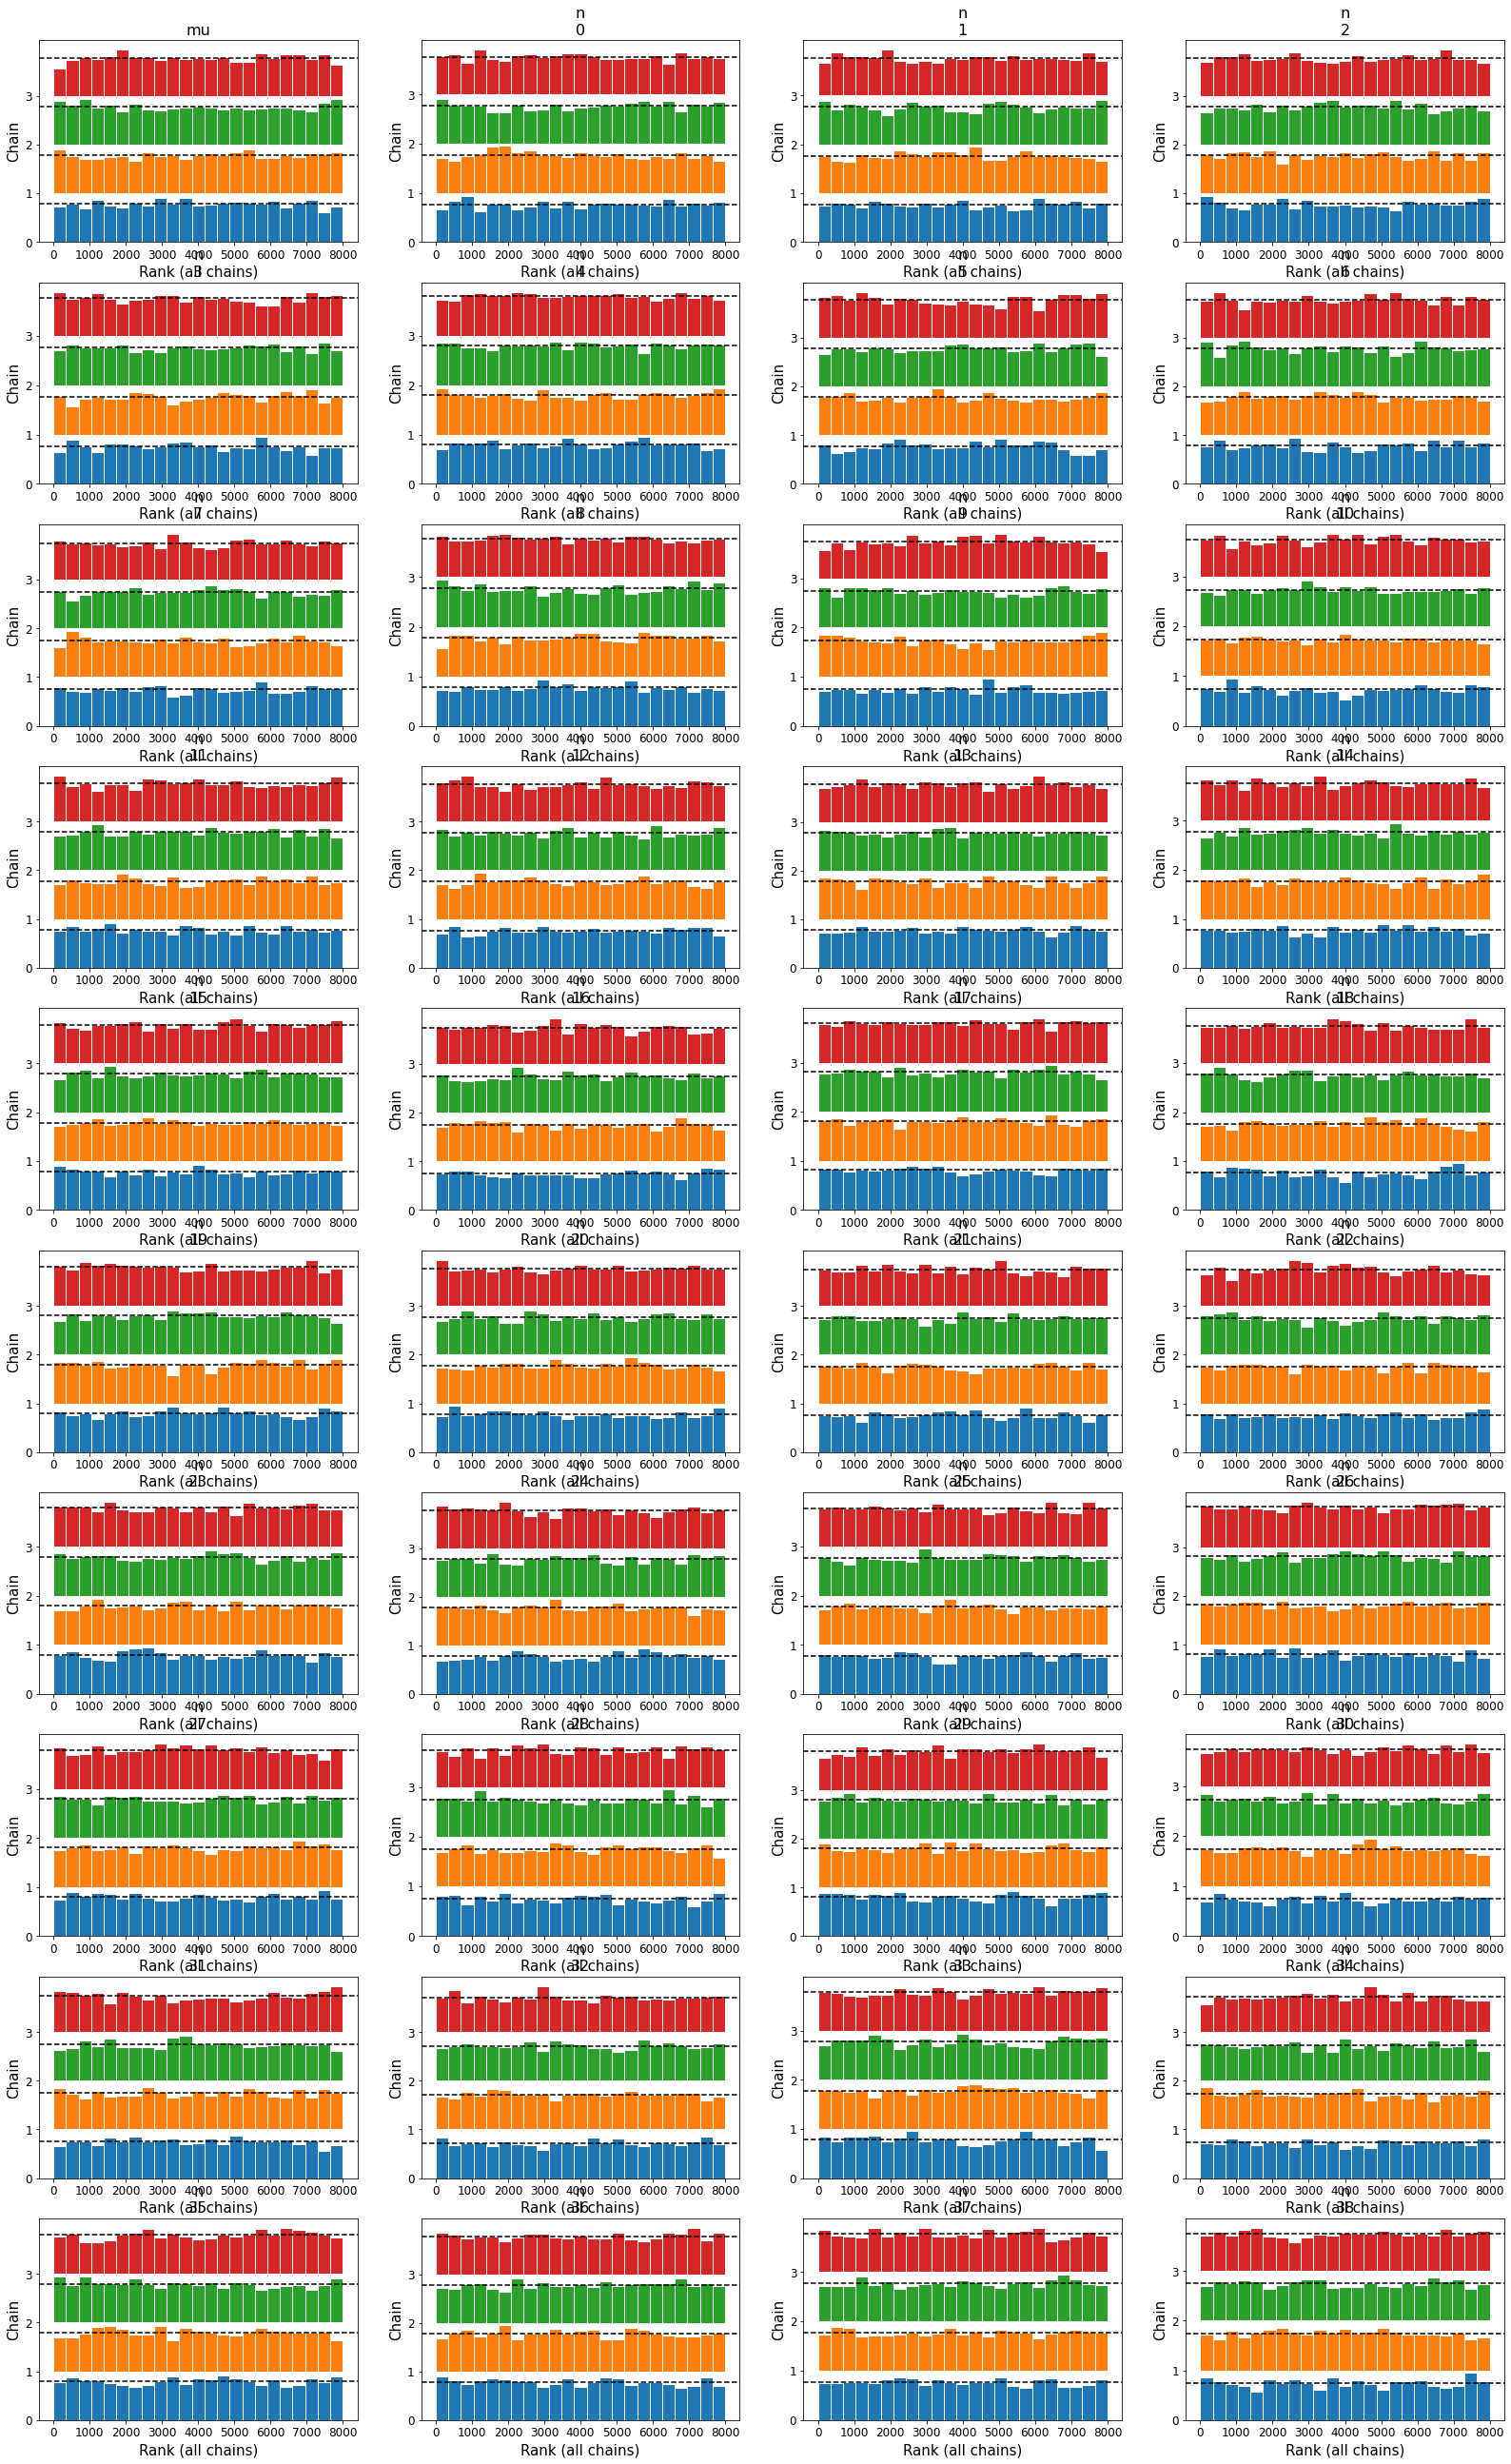

In [29]:
# diagnostic visuals
az.plot_rank(inferencep)
display(az.summary(inferencep))

# diagnostic checks
assert all(az.rhat(inferencep) <= 1.01)
assert all(az.ess(inferencep) > n_samples/10)

$\hat{R}$ for all parameters are <= 1.01, and effective sample sizes are greater than 10% of the sample size. Furthermore, the rank plots look roughly uniformly-distributed. Since the diagnostic checks are all fine, we have no reason to expect that the sampler is working incorrectly. We thus assume that it is 'randomly' sampling from the entire posterior distribution.

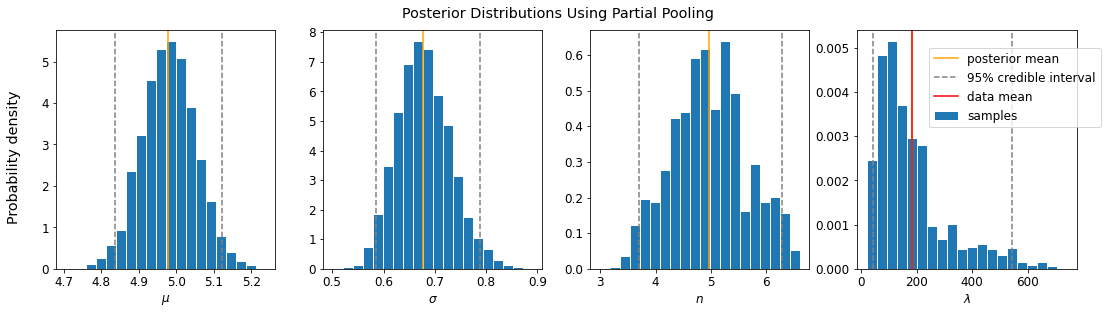

95% credible interval for l: [40.06, 541.44]
Posterior mean of l: 180.55
Data mean: 180.53


In [51]:
fig, ax = plt.subplots(1, 4, figsize = (15, 4))
fig.tight_layout(pad = 1)
var = ['mu', 'sigma', 'n', 'l']
xlabel = ['$\mu$', '$\sigma$', '$n$', '$\lambda$']

# plot posterior for each variable
for i in range(4):
    valsp = inferencep.posterior[var[i]].values.flatten()

    ax[i].hist(valsp, bins = 20, edgecolor = 'white', density = True, label = 'samples')
    ax[i].axvline(np.mean(valsp), color = 'orange', label = 'posterior mean')
    ax[i].axvline(np.percentile(valsp, 2.5), color = 'gray', linestyle = '--', label = '95% credible interval')
    ax[i].axvline(np.percentile(valsp, 97.5), color = 'gray', linestyle = '--')
    ax[i].set_xlabel(xlabel[i])
    
    if i == 3:
        ax[i].axvline(np.mean(d), color = 'red', label = 'data mean')
        ax[i].legend(bbox_to_anchor=(0.3, 0.95))
        
fig.supylabel('Probability density', x = -0.01)
fig.suptitle('Posterior Distributions Using Partial Pooling', y = 1.02)
plt.show()

l_valsp = inferencep.posterior.l.values.flatten()
print('95% credible interval for l:', [round(np.percentile(l_valsp, 2.5), 2), round(np.percentile(l_valsp, 97.5), 2)])
print('Posterior mean of l:', round(np.mean(l_valsp), 2))
print('Data mean:', round(np.mean(d), 2))

Plotting all posterior samples, we see that there is a much greater variance in the posterior over $\lambda$ than with the complete pooling model. There is a 95% probability that the true value of $\lambda$ for our partial pooling model is between ~40 and ~541, a much wider range than for complete pooling. Inkeeping with the complete pooling model, the posterior mean and the data mean are equivalent.

This distribution, however, doesn't tell us much about the distributions over $\lambda$ for each grid cell. We can also plot the individual distributions, as below.

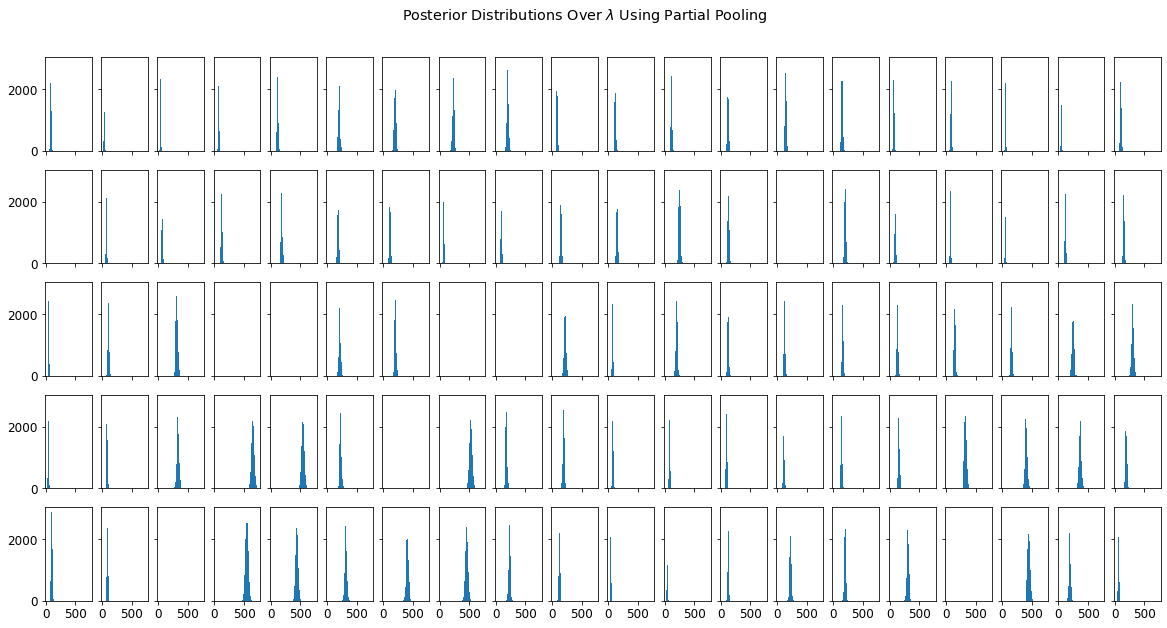

In [52]:
x = len(data)
y = len(data[0])

# plot each posterior distribution in the corresponding cell
fig, ax = plt.subplots(x, y, figsize = (20, 10), sharex = True, sharey = True)
idx = 0

for i in range(x):
    for j in range(y):
        
        # empty grids cells
        if str(data[i][j]) == 'nan':
            continue

        # plot posterior for each lambda
        ax[x-i-1][j].hist(inferencep.posterior.l[:, :, idx].values.flatten())
        idx += 1

fig.suptitle('Posterior Distributions Over $\lambda$ Using Partial Pooling', y = 0.95)
plt.show()

Though the above plot is difficult to draw much information from, we can get a broad overview from this image. We can see that distributions that lie more to the right correspond to light colours on our gridplot and thus higher counts, and vice versa. We can also see that there is a high variation in the distributions. We can zoom into some of these plots to extract more information from them.

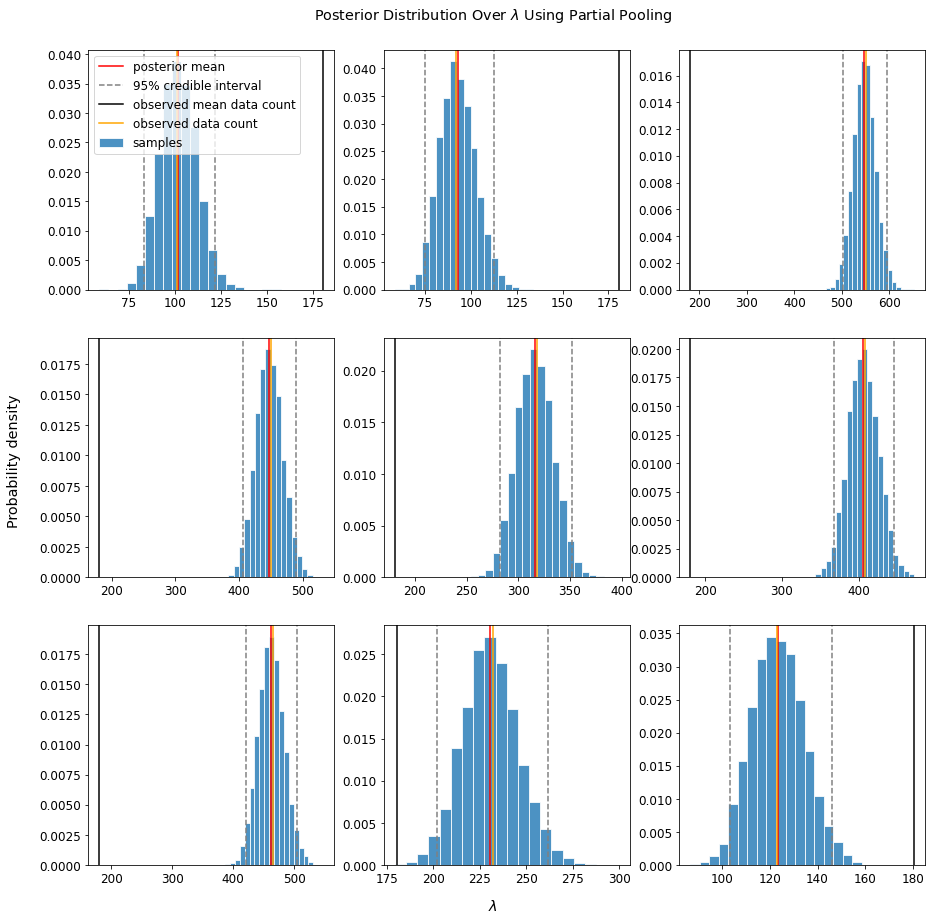

In [55]:
fig, ax = plt.subplots(3, 3, figsize = (15, 15))

# first 9 lambda distributions
for i in range(3):
    for j in range(3):

        l_valsp = inferencep.posterior.l[:, :, 3*i+j].values.flatten()

        # posterior samples
        ax[i][j].hist(l_valsp, bins = 20, edgecolor = 'white', density = True, label = 'samples', alpha = 0.8)

        # posterior mean and credible interval
        ax[i][j].axvline(np.mean(l_valsp), color = 'red', label = 'posterior mean')
        ax[i][j].axvline(np.percentile(l_valsp, 2.5), color = 'gray', linestyle = '--', label = '95% credible interval')
        ax[i][j].axvline(np.percentile(l_valsp, 97.5), color = 'gray', linestyle = '--')

        # data mean and individual count
        ax[i][j].axvline(np.mean(d), color = 'black', label = 'observed mean data count')
        ax[i][j].axvline(d[3*i+j], color = 'orange', label = 'observed data count')
        
        if i == 0 and j == 0:
            ax[i][j].legend()

fig.supxlabel('$\lambda$', y = 0.08)
fig.supylabel('Probability density', x = 0.05)
fig.suptitle('Posterior Distribution Over $\lambda$ Using Partial Pooling', y = 0.92)
plt.show()

From the posterior distributions, we see that the posterior mean for each $\lambda$ doesn't lie exactly on the count for that grid cell. Instead, the posterior mean is slightly shifted towards the overall mean (shrinkage). This is because we aren't modelling the grid cells to be entirely independent (their priors come from the same distribution), and so the mean for each is slightly shifted away from the count for that grid cell towards the mean count of all grid cells.

## Making Predictions

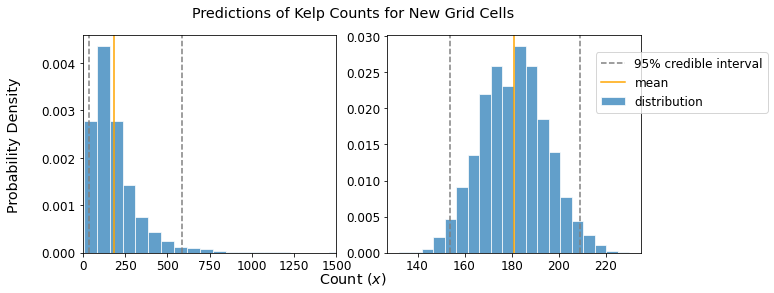

95% credible interval for complete pooling prediction counts: [154.0, 209.0]
95% credible interval for partial pooling prediction counts: [36.0, 585.0249999999996]

Mean complete pooling prediction counts: 180.820875
Mean partial pooling prediction counts: 186.9335


In [74]:
import scipy.stats as sts

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

# partial pooling predictions
n_partial = sts.norm.rvs(loc = inferencep.posterior.mu.values.flatten(), 
             scale = inferencep.posterior.sigma.values.flatten())
l_partial = np.exp(n_partial)
x_partial = sts.poisson.rvs(mu = l_partial)

ax[0].hist(x_partial, density = True, edgecolor = 'white', bins = 20, alpha = 0.7)
ax[0].axvline(np.percentile(x_partial, 2.5), color = 'gray', linestyle = '--')
ax[0].axvline(np.percentile(x_partial, 97.5), color = 'gray', linestyle = '--')
ax[0].axvline(np.mean(x_partial), color = 'orange')
ax[0].set_xlim(0, 1500)

# complete pooling predictions
x_complete = sts.poisson.rvs(mu = inferencec.posterior.l.values.flatten())

ax[1].hist(x_complete, density = True, edgecolor = 'white', bins = 20, alpha = 0.7, label = 'distribution')
ax[1].axvline(np.percentile(x_complete, 2.5), color = 'gray', linestyle = '--', label = '95% credible interval')
ax[1].axvline(np.percentile(x_complete, 97.5), color = 'gray', linestyle = '--')
ax[1].axvline(np.mean(x_complete), color = 'orange', label = 'mean')
ax[1].legend(bbox_to_anchor=(0.8, 0.95))

fig.suptitle('Predictions of Kelp Counts for New Grid Cells')
fig.supxlabel('Count ($x$)')
fig.supylabel('Probability Density')
plt.show()

print('95% credible interval for complete pooling prediction counts:', [np.percentile(x_complete, 2.5), 
                                                                        np.percentile(x_complete, 97.5)])
print('95% credible interval for partial pooling prediction counts:', [np.percentile(x_partial, 2.5), 
                                                                        np.percentile(x_partial, 97.5)])
print('')
print('Mean complete pooling prediction counts:', np.mean(x_complete))
print('Mean partial pooling prediction counts:', np.mean(x_partial))

We can make predictions from the posterior distributions by using randomly sampling. For complete pooling, this involves taking samples from the poisson distribution with the rate parameter equal to the posterior samples for the rate. For partial pooling, we randomly sample from a normal distribution with the posterior samples for $\mu$ and $\sigma$, transform this by exponentiating it, and then draw samples from the poisson with this as the rate parameter. Plotting this, we see that the predictions for kelp counts for the new grid cells using partial pooling spread a much wider range and are less confident than that of complete pooling. When we compare the 95% credible intervals, we see that there is a 95% probability that the true count for a new grid cell lies between 36 and 585 for partial pooling, and 154 and 209 for complete pooling. 

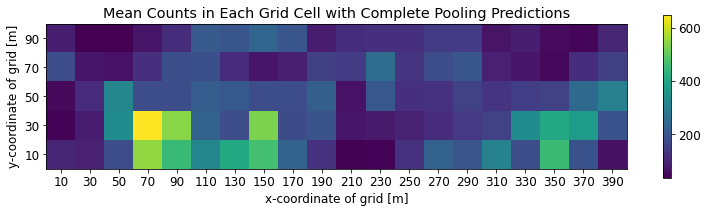

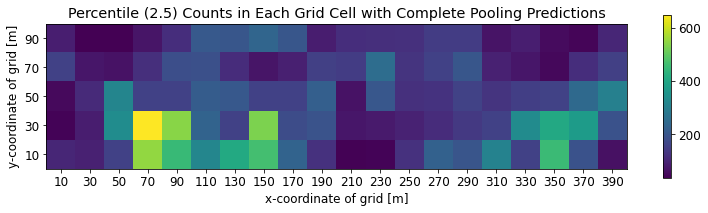

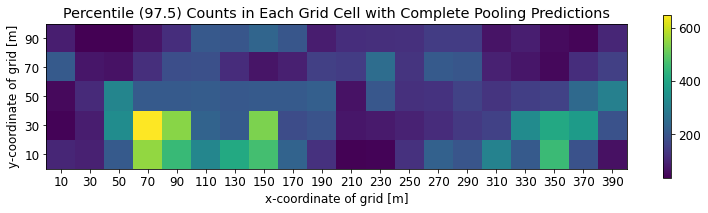

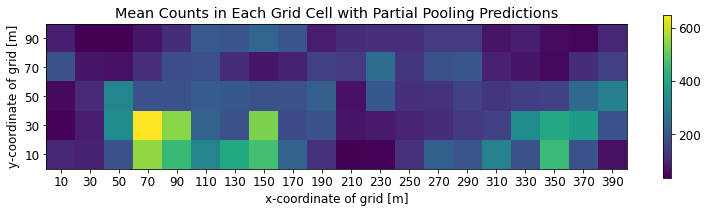

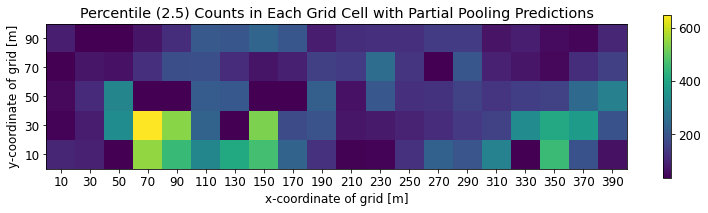

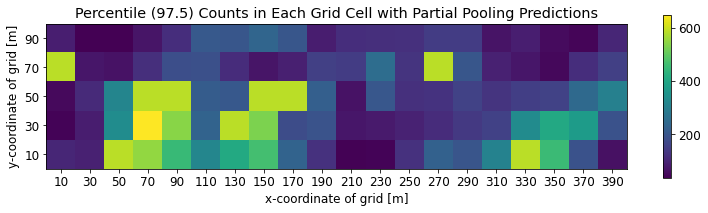

In [85]:
plots = [np.mean(x_complete), np.percentile(x_complete, 2.5), np.percentile(x_complete, 97.5), 
         np.mean(x_partial), np.percentile(x_partial, 2.5), np.percentile(x_partial, 97.5)]
var = ['Mean', 'Percentile (2.5)', 'Percentile (97.5)']*2
pooling = ['Complete']*3 + ['Partial']*3

for i in range(len(plots)):
    data_complete = np.nan_to_num(data, nan = plots[i])
    
    plt.figure(figsize=(13, 3))
    plt.title(f'{var[i]} Counts in New Grid Cells with {pooling[i]} Pooling Predictions')
    plt.xlabel('x-coordinate of grid [m]')
    plt.ylabel('y-coordinate of grid [m]')
    plt.imshow(data_complete, origin='lower')
    plt.xticks(np.arange(data_complete.shape[1]), np.array(grid_x, dtype=int))
    plt.yticks(np.arange(data_complete.shape[0]), np.array(grid_y, dtype=int))
    plt.colorbar()
    plt.show()

We can also look at these predictions visually. Plotting these on the count image, we see that complete pooling predictions do not vary much; it is difficult to see the difference between the 2.5 percentile, mean and 97.5 percentile for these predictions. However, when we fill in the empty grid cells with partial pooling predictions, we see that there is percievable differences between all three plots, the 2.5 percentile (very low count/dark squares), mean and 97.5 percentile (very high count/light squares).

When we plot the count predictions in this way, the partial pooling model seems to make more sense. The complete pooling model has a high degree of confidence in the count predictions and has a narrower variance than the partial pooling model. In reality, we have no reason to believe that the new predictions should be this certain. Instead, they should reflect the range of counts in the collected grid data. Partial pooling predictions spread over a wider range, and encompass this knowledge. Thinking back to the differences between the two models, we can understand that the partial pooling shows a wider range of predictions because we assume variation between grid cells by using hyperpriors such that each prior distribution is related, but not the same.